使用DCGAN生成Cat64*64数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = '/input/Cat64/'
LEARNING_RATE_D = 5e-5
LEARNING_RATE_G = 2e-4
IMAGE_CHANNEL = 3
IMAGE_SIZE = 64
BATCH_SIZE = 64
EPOCH = 100
NOISE_DIM = 100

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # Estimated variance, must be around 1
        m.weight.data.normal_(1.0, 0.02)
        # Estimated mean, must be around 0
        m.bias.data.fill_(0)

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 1024, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU()
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU()
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.deconv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

        weights_init(self)

    def forward(self, x):
        output = self.deconv1(x)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)
        output = self.deconv5(output)
        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 128, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )
        weights_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = output.view(-1)

        return output

# 3.模型

In [4]:
NetD = Discriminator()
NetG = Generator()
criterion = torch.nn.BCELoss()

x = torch.FloatTensor(BATCH_SIZE, IMAGE_CHANNEL, IMAGE_SIZE, IMAGE_SIZE)
y = torch.FloatTensor(BATCH_SIZE)
z = torch.FloatTensor(BATCH_SIZE, NOISE_DIM, 1, 1)
z_test = torch.FloatTensor(100, NOISE_DIM, 1, 1).normal_(0, 1)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    criterion = criterion.cuda()
    x = x.cuda()
    y = y.cuda()
    z = z.cuda()
    z_test = z_test.cuda()

optimizerD = torch.optim.Adam(NetD.parameters(),lr=LEARNING_RATE_D,betas=(0.5,0.999), weight_decay=0)
optimizerG = torch.optim.Adam(NetG.parameters(),lr=LEARNING_RATE_G,betas=(0.5,0.999), weight_decay=0)

transform=tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) ,
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.5]*3,[0.5]*3)
])

dataset = tv.datasets.ImageFolder(root=DATA_PATH, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4.训练

In [6]:
showbar = bar.ProgressBar(EPOCH, len(dataloader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    for i, data_batch in enumerate(dataloader, 0):
        for p in NetD.parameters():
            p.requires_grad = True

        NetD.zero_grad()
        images, labels = data_batch
        current_batch_size = images.size(0)
        images = images.cuda() if torch.cuda.is_available() else images
        x.data.resize_as_(images).copy_(images)
        y.data.resize_(current_batch_size).fill_(1)
        y_pred = NetD(x)
        errD_real = criterion(y_pred, y)
        errD_real.backward()
        D_real = y_pred.data.mean()

        z.data.resize_(current_batch_size,NOISE_DIM, 1, 1).normal_(0, 1)
        x_fake = NetG(z)
        y.data.resize_(current_batch_size).fill_(0)
        y_pred_fake = NetD(x_fake.detach())
        errD_fake = criterion(y_pred_fake, y)
        errD_fake.backward()
        D_fake = y_pred_fake.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        for p in NetD.parameters():
            p.requires_grad = False

        NetG.zero_grad()
        y.data.resize_(current_batch_size).fill_(1)
        y_pred_fake = NetD(x_fake)
        errG = criterion(y_pred_fake, y)
        errG.backward(retain_graph=True)
        D_G = y_pred_fake.data.mean()
        optimizerG.step()

        showbar.show(epoch, errD.item(), errG.item())

Epoch:1 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:1.331;G Loss:1.006,total=0:00:400
Epoch:2 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:1.109;G Loss:1.411,total=0:00:400
Epoch:3 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:1.122;G Loss:1.459,total=0:00:400
Epoch:4 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:1.261;G Loss:1.886,total=0:00:400
Epoch:5 / 100 [*****************************************************************************************************************************

Epoch:38 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:1.079;G Loss:1.568,total=0:00:40007:3023
Epoch:39 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.872;G Loss:2.179,total=0:00:40056:4330
Epoch:40 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.884;G Loss:2.896,total=0:00:40045:3500
Epoch:41 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.903;G Loss:2.488,total=0:00:40034:2518
Epoch:42 / 100 [********************************************************************************************

Epoch:74 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.387;G Loss:5.613,total=0:00:40015:1913
Epoch:75 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.234;G Loss:3.639,total=0:00:40039:1252
Epoch:76 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.192;G Loss:4.732,total=0:00:40003:2119
Epoch:77 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.310;G Loss:2.321,total=0:00:40011:3803
Epoch:78 / 100 [********************************************************************************************

# 5.生成

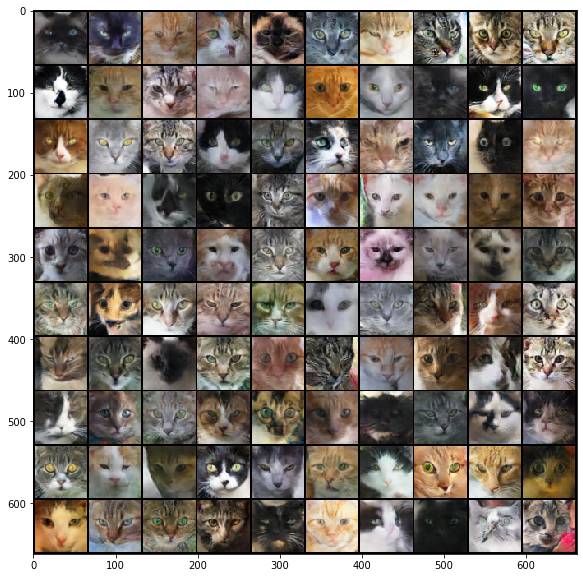

In [9]:
fake_u=NetG(z_test)
img = tv.utils.make_grid(fake_u.data, nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))